## Overview
In this notebook, I'll show you how to make a simple query on Craigslist using some nifty python modules. You can take advantage of all the structure data that exists on webpages to collect interesting datasets.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:
> `http://sfbay.craigslist.org/search/eby/apa?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1`

This is actually two separate things. The first tells craigslist what kind of thing we're searching for:

> `http://sfbay.craigslist.org/search/eby/apa` says we're searching in the sfbay area (`sfbay`) for apartments (`apa`) in the east bay (`eby`).

The second part contains the parameters that we pass to the search:

> `?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1` says we want 1+ bedrooms, cats allowed, dogs allowed, and furnished apartments. You can manually change these fields in order to create new queries.

## Getting a single posting

So, we'll use this knowledge to send some custom URLs to Craigslist. We'll do this using the `requests` python module, which is really useful for querying websites.

In [2]:
import requests

In internet lingo, we're posting a `get` requests to the website, which simply says that we'd like to get some information from the Craigslist website.  With requests, we can easily create a dictionary that specifies parameters in the URL:

In [3]:
url_base = 'http://sfbay.craigslist.org/search/eby/apa'
params = dict(bedrooms=1, is_furnished=1)
rsp = requests.get(url_base, params=params)

In [4]:
# Note that requests automatically created the right URL:
print(rsp.url)

http://sfbay.craigslist.org/search/eby/apa?bedrooms=1&is_furnished=1


In [23]:
# We can access the content of the response that Craigslist sent back here:
print(rsp.text[:500])

<!DOCTYPE html>

<html class="no-js"><head>
    <title>SF bay area apartments / housing rentals  - craigslist</title>

    <meta name="description" content="SF bay area apartments / housing rentals  - craigslist">
    <link rel="canonical" href="https://sfbay.craigslist.org/search/eby/apa">
    <link rel="alternate" type="application/rss+xml" href="https://sfbay.craigslist.org/search/eby/apa?bedrooms=1&amp;is_furnished=1&amp;format=rss" title="RSS feed for craigslist | SF bay area apartments / h


Wow, that's a lot of code. Remember, websites serve HTML documents, and usually your browser will automatically render this into a nice webpage for you. Since we're doing this with python, we get back the raw text. This is really useful, but how can we possibly parse it all?

For this, we'll turn to another great package, BeautifulSoup:

In [24]:
from bs4 import BeautifulSoup as bs4

# BS4 can quickly parse our text, make sure to tell it that you're giving html
html = bs4(rsp.text, 'html.parser')

# BS makes it easy to look through a document
print(html.prettify()[:1000])

<!DOCTYPE html>
<html class="no-js">
 <head>
  <title>
   SF bay area apartments / housing rentals  - craigslist
  </title>
  <meta content="SF bay area apartments / housing rentals  - craigslist" name="description">
   <link href="https://sfbay.craigslist.org/search/eby/apa" rel="canonical">
    <link href="https://sfbay.craigslist.org/search/eby/apa?bedrooms=1&amp;is_furnished=1&amp;format=rss" rel="alternate" title="RSS feed for craigslist | SF bay area apartments / housing rentals  - craigslist " type="application/rss+xml">
     <meta content="initial-scale=1.0, user-scalable=1" name="viewport">
      <link href="//www.craigslist.org/styles/cl.css?v=804a233c4671d1518577df0ed14ea69a" media="all" rel="stylesheet" type="text/css">
       <link href="//www.craigslist.org/styles/tocs.css?v=9ff241f00dede652691d87d06e044903" media="all" rel="stylesheet" type="text/css">
        <link href="//www.craigslist.org/styles/jquery-ui-1.9.2.custom.css?v=86db72e37d2cf63cab3c63485c71becb" media="al

Beautiful soup lets us quickly search through an HTML document. We can pull out whatever information we want.

Scanning through this text, we see a common structure repeated `<p class="row">`. This seems to be the container that has information for a single apartment.

In BeautifulSoup, we can quickly get all instances of this container:

In [8]:
# find_all will pull entries that fit your search criteria.
# Note that we have to use brackets to define the `attrs` dictionary
# Because "class" is a special word in python, so we need to give a string.
apts = html.find_all('p', attrs={'class': 'row'})
print(len(apts))

100


Now let's look inside the values of a single apartment listing:

In [9]:
# We can see that there's a consistent structure to a listing.
# There is a 'time', a 'name', a 'housing' field with size/n_brs, etc.
this_appt = apts[15]
print(this_appt.prettify())

<p class="row" data-pid="5196816429">
 <a class="i" data-ids="0:00z0z_6ExjrIcigl0,0:00P0P_ajl2aLvLzPZ,0:00505_fkV81ecr6Q7,0:00o0o_itBkVnRNB7x,0:00Z0Z_9nhz4hwSg89,0:00v0v_5e5olk84ORp,0:00o0o_gEeGCv5qex9,0:00s0s_jgjOfJN3Mnj,0:00R0R_eJ46CggAvLv,0:00F0F_lH29uVfpZuU,0:00l0l_ihXQjIr9FQd,0:00S0S_cGXG5S10Cb4,0:00d0d_j3e28Yr0qox,0:00909_5GyVUsiAmPe,0:00L0L_jsmM2yqMYyc,0:00S0S_cu9ZkDUA02b,0:00C0C_jpUCkGu1OP1" href="/eby/apa/5196816429.html">
 </a>
 <span class="txt">
  <span class="star">
  </span>
  <span class="pl">
   <time datetime="2015-08-29 13:04" title="Sat 29 Aug 01:04:08 PM">
    Aug 29
   </time>
   <a class="hdrlnk" data-id="5196816429" href="/eby/apa/5196816429.html">
    4-Bedroom home available December 20
   </a>
  </span>
  <span class="l2">
   <span class="price">
    $3600
   </span>
   <span class="housing">
    / 4br - 1800ft
    <sup>
     2
    </sup>
    -
   </span>
   <span class="pnr">
    <small>
     (alameda)
    </small>
    <span class="px">
     <span class="p">


In [10]:
# So now we'll pull out a couple of things we might be interested in:
# It looks like "housing" contains size information. We'll pull that.
# Note that `findAll` returns a list, since there's only one entry in
# this HTML, we'll just pull the first item.
size = this_appt.findAll(attrs={'class': 'housing'})[0].text
print(size)

/ 4br - 1800ft2 - 


We can query split this into n_bedrooms and the size. However, note that sometimes one of these features might be missing. So we'll use an `if` statement to try and capture this variability:

In [11]:
def find_size_and_brs(size):
    split = size.strip('/- ').split(' - ')
    if len(split) == 2:
        n_brs = split[0].replace('br', '')
        this_size = split[1].replace('ft2', '')
    elif 'br' in split[0]:
        # It's the n_bedrooms
        n_brs = split[0].replace('br', '')
        this_size = np.nan
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].replace('ft2', '')
        n_brs = np.nan
    return float(this_size), float(n_brs)
this_size, n_brs = find_size_and_brs(size)

In [12]:
# Now we'll also pull a few other things:
this_time = this_appt.find('time')['datetime']
this_time = pd.to_datetime(this_time)
this_price = float(this_appt.find('span', {'class': 'price'}).text.strip('$'))
this_title = this_appt.find('a', attrs={'class': 'hdrlnk'}).text

In [13]:
# Now we've got the n_bedrooms, size, price, and time of listing
print('\n'.join([str(i) for i in [this_size, n_brs, this_time, this_price, this_title]]))

1800.0
4.0
2015-08-29 13:04:00
3600.0
4-Bedroom home available December 20


## Querying lots of postings

Cool - so now we've got some useful information about one listing. Now let's loop through many listings across several locations.

It looks like there is a "city code" that distinguishes where you're searching. Here is a **not** up to date list: [link](https://sites.google.com/site/clsiteinfo/city-site-code-sort)

Within the Bay Area, there are also a lot of sub-regional locations, which we'll define here, then loop through them all.

Note that the `s` parameter tells Craiglist where to start in terms of the number of results given back. E.g., if s==100, then it starts at the 100th entry.

In [14]:
loc_prefixes = ['eby', 'nby', 'sfc', 'sby', 'scz']

We'll define a few helper functions to handle edge cases and make sure that we don't get any errors.

In [15]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

def find_times(results):
    times = []
    for rw in apts:
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

Now we're ready to go. We'll loop through all of our locations, and pull a number of entries for each one. We'll use a pandas dataframe to store everything, because this will be useful for future analysis.

**Note** - Craigslist won't take kindly to you querying their server a bunch of times at once. Make sure not to pull too much data too quickly. Another option is to add a delay to each loop iteration. Otherwise your IP might get banned.

In [16]:
# Now loop through all of this and store the results
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily
search_indices = np.arange(0, 300, 100)
for loc in loc_prefixes:
    print loc
    for i in search_indices:
        url = 'http://sfbay.craigslist.org/search/{0}/apa'.format(loc)
        resp = requests.get(url, params={'bedrooms': 1, 's': i})
        txt = bs4(resp.text, 'html.parser')
        apts = txt.findAll(attrs={'class': "row"})
        
        # Find the size of all entries
        size_text = [rw.findAll(attrs={'class': 'housing'})[0].text
                     for rw in apts]
        sizes_brs = [find_size_and_brs(stxt) for stxt in size_text]
        sizes, n_brs = zip(*sizes_brs)  # This unzips into 2 vectors
     
        # Find the title and link
        title = [rw.find('a', attrs={'class': 'hdrlnk'}).text
                      for rw in apts]
        links = [rw.find('a', attrs={'class': 'hdrlnk'})['href']
                 for rw in apts]
        
        # Find the time
        time = [pd.to_datetime(rw.find('time')['datetime']) for rw in apts]
        price = find_prices(apts)
        
        # We'll create a dataframe to store all the data
        data = np.array([time, price, sizes, n_brs, title, links])
        col_names = ['time', 'price', 'size', 'brs', 'title', 'link']
        df = pd.DataFrame(data.T, columns=col_names)
        df = df.set_index('time')
        
        # Add the location variable to all entries
        df['loc'] = loc
        results.append(df)
        
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

eby
nby
sfc
sby
scz


In [17]:
# We'll make sure that the right columns are represented numerically:
results[['price', 'size', 'brs']] = results[['price', 'size', 'brs']].convert_objects(convert_numeric=True)

In [18]:
# And there you have it:
results.head()

,price,size,brs,title,link,loc
time,,,,,,
2015-08-30 15:40:00,2187,610,1,UNIQUE LOFT! Vaulted ceilings! Granite & Stain...,/eby/apa/5198406276.html,eby
2015-08-30 15:39:00,2600,580,1,Elmwood - College Ave between Ashby and Alcatraz,/eby/apa/5198403987.html,eby
2015-08-30 15:38:00,3775,1232,2,"2 BEDROOM, 2 BATH CONDO AVAILABLE AT MERCER!",/eby/apa/5198395321.html,eby
2015-08-30 15:31:00,3023,1133,2,Stunning. Spectacular. Sprawling. This 2x2 has...,/eby/apa/5198383076.html,eby
2015-08-30 15:31:00,3100,NaN,3,Well mainted Fremont home with upgrades for a ...,/eby/apa/5183531302.html,eby


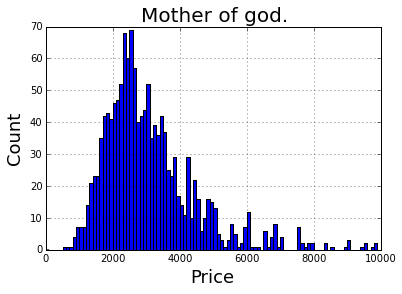

In [19]:
ax = results.hist('price', bins=np.arange(0, 10000, 100))[0, 0]
ax.set_title('Mother of god.', fontsize=20)
ax.set_xlabel('Price', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

In [20]:
# Finally, we can save this data to a CSV to play around with it later.
# We'll have to remove some annoying characters first:
import string
use_chars = string.ascii_letters +\
    ''.join([str(i) for i in range(10)]) +\
    ' /\.'
results['title'] = results['title'].apply(
    lambda a: ''.join([i for i in a if i in use_chars]))

results.to_csv('../data/craigslist_results.csv')

## RECAP
To sum up what we just did:

* We defined the ability to query a website using a custom URL. This is usually the same in structure for website, but the parameter names will be different.
* We sent a `get` request to Craigslist using the `requests` module of python.
* We parsed the response using `BeautifulSoup4`.
* We then looped through a bunch of apartment listings, pulled some relevant data, and combined it all into a cleaned and usable dataframe with `pandas`.

Next up I'll take a look at the data, and see if there's anything interesting to make of it.

## Bonus - auto-emailing yourself w/ notifications
A few people have asked me about using this kind of process to make a bot that scrapes craigslist periodically. This is actually quite simple, as it basically involves pulling the top listings from craigslist, checking this against an "old" list, and detecting if there's anything new that has popped up since the last time you checked.

Here's a simple script that will get the job done. Once again, don't pull too much data at once, and don't query Craigslist too frequently, or you're gonna get banned.

In [ ]:
# We'll use the gmail module (there really is a module for everything in python)
import gmail
import time

In [ ]:
gm = gmail.GMail('my_username', 'my_password')
gm.connect()

# Define our URL and a query we want to post
base_url = 'http://sfbay.craigslist.org/'
url = base_url + 'search/eby/apa?nh=48&anh=49&nh=112&nh=58&nh=61&nh=62&nh=66&max_price=2200&bedrooms=1'

# This will remove weird characters that people put in titles like ****!***!!!
use_chars = string.ascii_letters + ''.join([str(i) for i in range(10)]) + ' '

In [ ]:
link_list = []  # We'll store the data here
link_list_send = []  # This is a list of links to be sent
send_list = []  # This is what will actually be sent in the email

# Careful with this...too many queries == your IP gets banned temporarily
while True:
    resp = requests.get(url)
    txt = bs4(resp.text, 'html.parser')
    apts = txt.findAll(attrs={'class': "row"})
    
    # We're just going to pull the title and link
    for apt in apts:
        title = apt.find_all('a', attrs={'class': 'hdrlnk'})[0]
        name = ''.join([i for i in title.text if i in use_chars])
        link = title.attrs['href']
        if link not in link_list and link not in link_list_send:
            print('Found new listing')
            link_list_send.append(link)
            send_list.append(name + '  -  ' + base_url+link)
            
    # Flush the cache if we've found new entries
    if len(link_list_send) > 0:
        print('Sending mail!')
        msg = '\n'.join(send_list)
        m = email.message.Message()
        m.set_payload(msg)
        gm.send(m, ['recipient_email@mydomain.com'])
        link_list += link_list_send
        link_list_send = []
        send_list = []
    
    # Sleep a bit so CL doesn't ban us
    sleep_amt = np.random.randint(60, 120)
    time.sleep(sleep_amt)

And there you have it - your own little bot to keep you on the top of the rental market.